<a href="https://colab.research.google.com/github/RomillyClose/scalable-computing-examples/blob/main/LPS_training_exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LPS Hands-on Training Session - CoMet Toolkit: Uncertainties made easy**

#Exercise 1: Explore some of the basic functionality of the punpy tool.

## Objectives

In this exercise we will:

* Get familiar with the [**punpy**](https://punpy.readthedocs.io/en/latest/) tool.
* Propagate uncertainties on manually provided input data through a simple measurement functions using [**punpy**](https://punpy.readthedocs.io/en/latest/).
* Explore the various ways uncertainties with different error correlations can be propagated.


## *Step 1* - Set up the environment

First, install the obsarray package (flag handling and accessing uncertainties), the punpy package (uncertainty propagation) and the matheo package (for band integration).

In [1]:
!pip install obsarray>=1.0.3
!pip install punpy>=1.0.6

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.1 which is incompatible.


Please hit `Runtime > Restart Session` to properly load these packages into your Google Colab environment...

Then, import the relevant python packages required in this training:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import punpy

❗Note: If this import fails, it is likely because the pip installation has not properly updated in the Google colab session. Please restart session (in runtime tab above).

## *Step 2* - Define measurement function and input data

In this exercise, our aim is to get familiar with the basic functionality of punpy. Here, punpy will be used as a standalone tool (i.e. without combining it with obsarray functionality). We will use an example of a very basic sensor calibration, where we have some digital numbers for the signal (referred to as L0) and the gains (typically obtained from a lab calibration) to convert these to a physical quantity (referred to as L1). E.g., this could be a radiance measurement collected by an in-situ instrument.  

First, we define our measurement function. For use in punpy, this measurement function needs to be written as a Python function that takes the input quantities (on which we have uncertainties available) as arguments and the measurand (to which we want to propagate the uncertainties) as return. For some further information on measurement functions, input quantities and measurand, see the [CoMet webpage](https://www.comet-toolkit.org/user-guide/theory/).

In [2]:
# your measurement function
def calibrate(L0,gains):
   return L0*gains

Here, the measurement function is a very simple analytical function. However, in practice, this measurement function can contain as much complexity (including calls to other packages/external software, ...) as needed. To some extent, the measurement function is treated as a black box, as long as the measurand and input quantities are structured as expected.

Next, we define some example input data. For your own use case, you need to have this information available from other sources (i.e. the input uncertainties need to be understood prior to using punpy).

In [3]:
# your data
wavs = np.array([350,450,550,650,750])
L0 = np.array([0.43,0.8,0.7,0.65,0.9])
gains = np.array([23,26,28,29,31])

# your uncertainties
L0_ur = L0*0.05                             # 5% random uncertainty
L0_us = np.ones(5)*0.03                     # systematic uncertainty of 0.03

gains_ur = np.array([0.5,0.7,0.6,0.4,0.1])  # random uncertainty
gains_us = np.array([0.1,0.2,0.1,0.4,0.3])  # systematic uncertainty


## *Step 3* - Propagate the random and systematic uncertainties separately

After defining the data, the resulting uncertainty budget can then be calculated with punpy using the Monte Carlo (MC) method. First, we propagate the random and systematic uncertainties separately, and then combine the resulting L1 uncertainties. Their error correlations are combined using some helper functions.

In [4]:
# initialise a punpy MCpropagation object with 10000 MC samples
prop=punpy.MCPropagation(10000)

# apply the measuremnet function to calculate the measurand from the input quantities
L1=calibrate(L0,gains)

# propagate random uncertainties
# The format for the inputs is propagate_random(measurement function, [list of function inputs], [list of uncertainties in the same order of inputs])
L1_ur=prop.propagate_random(calibrate,[L0,gains],
      [L0_ur,gains_ur])

# propagate systematic uncertainties
L1_us=prop.propagate_systematic(calibrate,[L0,gains],
      [L0_us,gains_us])

# combine random and systematic uncertainties
L1_ut=(L1_ur**2+L1_us**2)**0.5

# calculate random and systematic error correlation matrices (this is done by first combining covariances)
L1_cov=(punpy.convert_corr_to_cov(np.eye(len(L1_ur)),L1_ur)                   # random uncertainties have an identity matrix as the error correlation
        + punpy.convert_corr_to_cov(np.ones((len(L1_us),len(L1_us))),L1_us))  # systematic uncertainties have a matrix full of ones as the error correlation
L1_corr=punpy.correlation_from_covariance(L1_cov)

# print the results
print("L1:    ",L1)
print("L1_ur: ",L1_ur)
print("L1_us: ",L1_us)
print("L1_ut: ",L1_ut)
print("L1_cov:\n",L1_cov)
print("L1_corr:\n",L1_corr)

L1:     [ 9.89 20.8  19.6  18.85 27.9 ]
L1_ur:  [0.53596664 1.16799867 1.06473477 0.96081094 1.39409834]
L1_us:  [0.68698342 0.79124622 0.83761762 0.90232941 0.96230769]
L1_ut:  [0.87132454 1.41077691 1.35471894 1.31808802 1.69397352]
L1_cov:
 [[0.75920646 0.54357304 0.57542942 0.61988535 0.66108943]
 [0.54357304 1.99029148 0.66276178 0.71396474 0.76142233]
 [0.57542942 0.66276178 1.83526341 0.75580701 0.80604588]
 [0.61988535 0.71396474 0.75580701 1.73735603 0.86831854]
 [0.66108943 0.76142233 0.80604588 0.86831854 2.86954628]]
L1_corr:
 [[1.         0.44220089 0.48748686 0.53974299 0.44789236]
 [0.44220089 1.         0.3467767  0.38394941 0.31861091]
 [0.48748686 0.3467767  1.         0.42326982 0.35123998]
 [0.53974299 0.38394941 0.42326982 1.         0.38889113]
 [0.44789236 0.31861091 0.35123998 0.38889113 1.        ]]


We can then plot and inspect the results:

In [5]:
# define plot to show results
def make_plots_L1(L1,L1_ur=None,L1_us=None,L1_ut=None,L1_corr=None):
  if L1_cov is not None:
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
  else:
    fig,ax1 = plt.subplots(1,figsize=(5,5))

  ax1.plot(wavs,L1,"o")
  if L1_ur is not None:
    ax1.errorbar(wavs,L1,yerr=L1_ur,label="random uncertainty",capsize=5)
  if L1_us is not None:
    ax1.errorbar(wavs,L1,yerr=L1_us,label="systematic uncertainty",capsize=5)
  if L1_ut is not None:
    ax1.errorbar(wavs,L1,yerr=L1_ut,label="total uncertainty",capsize=5)
  ax1.legend()
  ax1.set_xlabel("wavelength (nm)")
  ax1.set_ylabel("radiance")
  ax1.set_title("L1 uncertainties")
  if L1_cov is not None:
    ax2.set_title("L1 correlation")
    cov_plot=ax2.imshow(L1_corr)
    plt.colorbar(cov_plot,ax=ax2)
  plt.show()

Similarly, we can plot the results for L1 data:

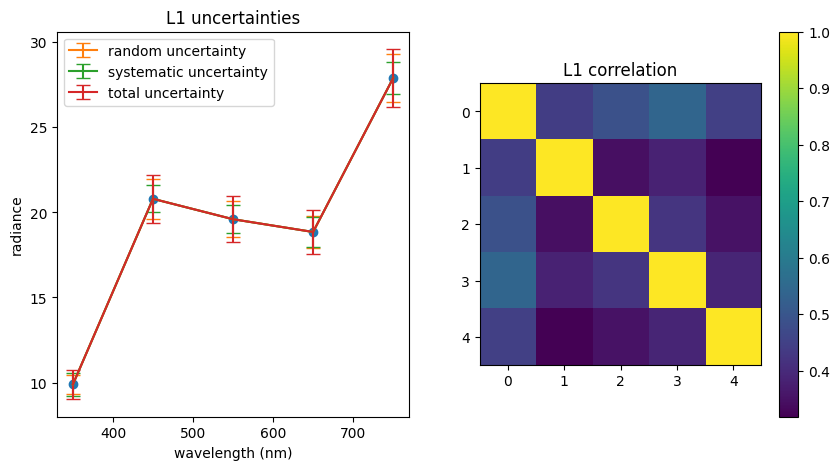

In [6]:
make_plots_L1(L1,L1_ur,L1_us,L1_ut,L1_corr) # make and display plot

## *Step 4* - Propagate uncertainties with an error correlation matrix

Instead of separately propagating the random and systematic uncertainties, we can also achieve the same result by first combining the random and systematic uncertainties on the input, and then propagating the total uncertainties and their error correlaiton. In this case, the error correlation needs to be explicitely passed to the `propagate_standard' function.

L1:     [ 9.89 20.8  19.6  18.85 27.9 ]
L1_ut:  [0.87771557 1.41985326 1.35295265 1.33873842 1.72048132]
L1_corr:
 [[1.         0.43495582 0.48740073 0.51656994 0.44089505]
 [0.43495582 1.         0.35068049 0.37327285 0.3204577 ]
 [0.48740073 0.35068049 1.         0.40236252 0.34529313]
 [0.51656994 0.37327285 0.40236252 1.         0.38685986]
 [0.44089505 0.3204577  0.34529313 0.38685986 1.        ]]


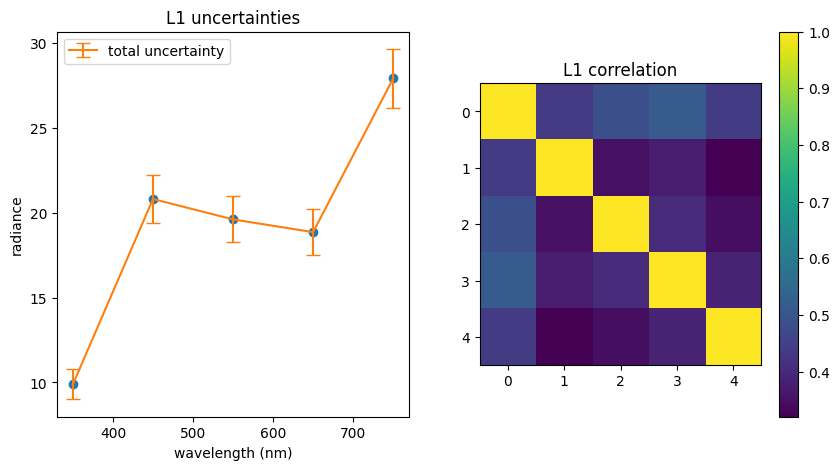

In [7]:
# first combine the random and systemtic uncertainties on the inputs
L0_ut=(L0_ur**2+L0_us**2)**0.5
gains_ut=(gains_ur**2+gains_us**2)**0.5

# combine the error correlation matrices on the inputs (by combining the error covariances)
L0_cov=punpy.convert_corr_to_cov(np.eye(len(L0_ur)),L0_ur)+\
       punpy.convert_corr_to_cov(np.ones((len(L0_us),len(L0_us))),L0_us)
L0_corr=punpy.correlation_from_covariance(L0_cov)

gains_cov=punpy.convert_corr_to_cov(np.eye(len(gains_ur)),gains_ur)+\
       punpy.convert_corr_to_cov(np.ones((len(gains_us),len(gains_us))),gains_us)
gains_corr=punpy.correlation_from_covariance(gains_cov)

# propagate the combined uncertainties and error correlation
L1_ut, L1_corr=prop.propagate_standard(calibrate,[L0,gains],
      [L0_ut,gains_ut],[L0_corr,gains_corr], return_corr=True)

# print results
print("L1:    ",L1)
print("L1_ut: ",L1_ut)
print("L1_corr:\n",L1_corr)
make_plots_L1(L1,L1_ut=L1_ut,L1_corr=L1_corr)

## **Exercise**

Let's add an additional variable to the measurement function, and propagate uncertainties.
In the previous example, we calibrated an in-situ instrument by applying gains to the digital numbers.
Now, let's add some dark measurements, which are subtracted from the digital numbers.

Here is the updated measurement function with the additional input data.

In [8]:
# updated measurement function
def calibrate(L0,gains,dark):
   return (L0-dark)*gains

# additional input quantity
dark = np.array([0.05,0.03,0.04,0.05,0.06])
dark_ur = np.array([0.02,0.02,0.02,0.02,0.02])  # random uncertainty

Try this yourself: propagate the uncertainties through this measurement function, based on the examples above. (❗Note: there are no systematic uncertainties on the darks, set them to zero if required).

In [12]:
# Enter your code here

# initialise a punpy MCpropagation object with 10000 MC samples
prop=punpy.MCPropagation(10000)

# apply the measuremnet function to calculate the measurand from the input quantities
L1=calibrate(L0,gains,dark)

# propagate random uncertainties
# The format for the inputs is propagate_random(measurement function, [list of function inputs], [list of uncertainties in the same order of inputs])
L1_ur=prop.propagate_random(calibrate,[L0,gains,dark],
      [L0_ur,gains_ur,dark_ur])
dark_us=np.zeros(5)
# propagate systematic uncertainties
L1_us=prop.propagate_systematic(calibrate,[L0,gains,dark],
      [L0_us,gains_us,dark_us])

# combine random and systematic uncertainties
L1_ut=(L1_ur**2+L1_us**2)**0.5

# calculate random and systematic error correlation matrices (this is done by first combining covariances)
L1_cov=(punpy.convert_corr_to_cov(np.eye(len(L1_ur)),L1_ur)                   # random uncertainties have an identity matrix as the error correlation
        + punpy.convert_corr_to_cov(np.ones((len(L1_us),len(L1_us))),L1_us))  # systematic uncertainties have a matrix full of ones as the error correlation
L1_corr=punpy.correlation_from_covariance(L1_cov)

# print the results
print("L1:    ",L1)
print("L1_ur: ",L1_ur)
print("L1_us: ",L1_us)
print("L1_ut: ",L1_ut)
print("L1_cov:\n",L1_cov)
print("L1_corr:\n",L1_corr)

L1:     [ 8.74 20.02 18.48 17.4  26.04]
L1_ur:  [0.69513124 1.27230743 1.20328156 1.13171948 1.52218004]
L1_us:  [0.69278835 0.79698538 0.84470386 0.90467889 0.96589082]
L1_ut:  [0.98140875 1.50131672 1.47017384 1.44887297 1.80276931]
L1_cov:
 [[0.96316314 0.55214219 0.585201   0.626751   0.66915791]
 [0.55214219 2.25395189 0.67321662 0.72101584 0.76980086]
 [0.585201   0.67321662 2.16141111 0.76418574 0.81589171]
 [0.626751   0.72101584 0.76418574 2.09923288 0.87382103]
 [0.66915791 0.76980086 0.81589171 0.87382103 3.24997717]]
L1_corr:
 [[1.         0.37473882 0.40558925 0.44077281 0.37821481]
 [0.37473882 1.         0.30500982 0.33146843 0.28442379]
 [0.40558925 0.30500982 1.         0.35875663 0.30783902]
 [0.44077281 0.33146843 0.35875663 1.         0.33454306]
 [0.37821481 0.28442379 0.30783902 0.33454306 1.        ]]


**Question**: What are the total uncertainties (including uncertainties on the dark measurements)?
Please copy-paste your result in the Mentimeter.

## *Step 5* - Error correlation between variables

In addition to having a correlation along one or more dimensions of a given variable, it is also possible that two variables are correlated (for example because they are measured using the same sensor). This can be specified in punpy by using the corr_between keyword. In the example below, the systematic errors in the darks and L0 data are fully correlated.

/usr/local/lib/python3.11/dist-packages/comet_maths/linear_algebra/matrix_calculation.py:274: UserWarning: One of the correlation matrices is not positive definite. It has been slightly changed (maximum difference of 2.220446049250313e-16) to accomodate our method.
  warnings.warn(


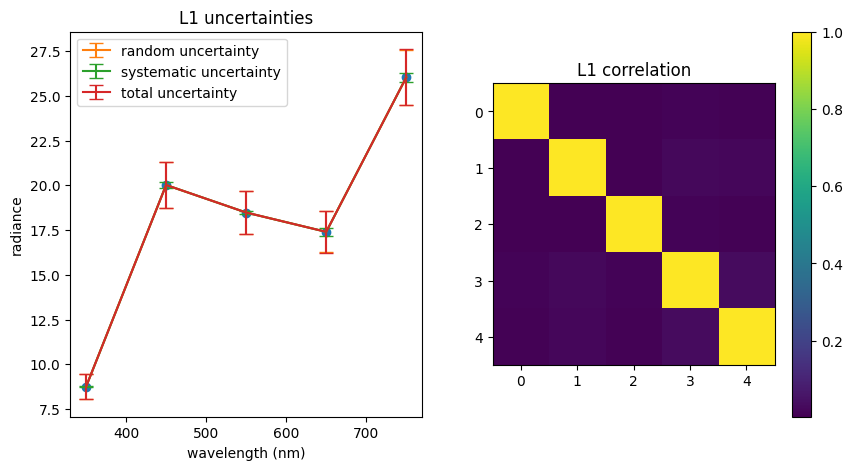

In [13]:
# We here define some systematic uncertainties for the darks, which are the same as for the digital numbers
dark_us = L0_us

# We then define how the errors for the different variables are correlated
corr_var=np.array([[1,0,1],   # here a 1 means the variables are fully correlated, and a 0 means uncorrelated
                   [0,1,0],   # on the diagonal there are 1's because each variable is fully correlated with itself
                   [1,0,1]])  # there are also 1's on the (0,2) and (2,0) locations, indicating the 1st and last variable (i.e. L0 and dark) are correlated

# We then recalculate the uncertainties and make a plot
L1_ur=prop.propagate_random(calibrate,[L0,gains,dark],
      [L0_ur,gains_ur,dark_ur])
L1_us=prop.propagate_systematic(calibrate,[L0,gains,dark],
      [L0_us,gains_us,dark_us],corr_between=corr_var)

L1_ut=(L1_ur**2+L1_us**2)**0.5

L1_cov=punpy.convert_corr_to_cov(np.eye(len(L1_ur)),L1_ur)+\
       punpy.convert_corr_to_cov(np.ones((len(L1_us),len(L1_us))),L1_us)
L1_corr=punpy.correlation_from_covariance(L1_cov)

make_plots_L1(L1,L1_ur,L1_us,L1_ut,L1_corr)

Note: sometimes there is a warning that one of the error correlation matrices is not positive definite (which can be ignored). This can happen due to the random nature of Monte Carlo and numerical accuracy. CoMet slightly modifies these error correlation matrices to correct for this.

## *Step 6* - Punpy keywords

There are many keywords that can be passed to the punpy functions to control the detailed behaviour. For a detailed description refer to the [punpy documentation](https://punpy.readthedocs.io/en/latest/content/generated/punpy.mc.mc_propagation.MCPropagation.propagate_standard.html). An additional features we would like to highlight is the ability to return the individual MC samples that were used, for manual inspection:

In [14]:
L1_ut, L1_corr, MCsamples_L1, MCsamples_L0=prop.propagate_standard(calibrate,[L0,gains,dark],
      [L0_ut,gains_ut,dark_ur],[L0_corr,gains_corr,"rand"], return_corr=True, return_samples=True)  # the return_samples keyword is set to True
print(MCsamples_L0,MCsamples_L1)

[array([[0.42981664, 0.80165708, 0.66377971, 0.66014586, 0.8468432 ],
        [0.3868607 , 0.75162903, 0.68508153, 0.60437432, 0.89249349],
        [0.40766576, 0.79202858, 0.63464898, 0.59527923, 0.86999634],
        ...,
        [0.44717092, 0.78721602, 0.67810485, 0.63225757, 0.93751944],
        [0.47981019, 0.78883217, 0.71625542, 0.65297504, 0.95967103],
        [0.45506691, 0.78998128, 0.68051624, 0.63934582, 0.96863353]],
       shape=(10000, 5))
 array([[23.31635112, 25.47375775, 27.55093955, 28.75126019, 30.45674629],
        [23.03184174, 25.91463678, 28.50119352, 29.58624712, 31.07000904],
        [22.8884078 , 25.0530691 , 29.24086629, 28.61587603, 30.93625197],
        ...,
        [22.83083047, 26.82428275, 28.75900018, 28.86451826, 30.75590026],
        [23.6592149 , 25.61703772, 27.07143498, 28.46485723, 31.31639364],
        [22.67466889, 27.29055587, 27.39886897, 28.81652349, 30.88518016]],
       shape=(10000, 5))
 array([[0.04926804, 0.05053008, 0.04247745, 0.03578

In these dark samples, there are some negative values. Depending on the use case, this might be considered unphysical.

Furthermore, it is possible to use different probability density functions (PDF) instead of the default Gaussian PDF. E.g., it is possible to define a lower boundary for the values in the MCsamples of the inputs, and thus avoid negative outputs:

In [15]:
L1_ut, MCsamples_L1, MCsamples_L0 = prop.propagate_standard(calibrate,[L0,gains,dark],
      [L0_ut,gains_ut,dark_ur],[L0_corr,gains_corr,"rand"], return_corr=False, return_samples=True, pdf_shape="truncated_gaussian", pdf_params={"min":0.})  # the pdf shape is set to truncated gaussian, and pdf_param is a dictionary that allows to set the minimum and maximum value
print(MCsamples_L0,MCsamples_L1)

[array([[0.46324569, 0.80041756, 0.70053735, 0.72481914, 0.95190278],
        [0.40180499, 0.74500339, 0.66691843, 0.63232954, 0.93577934],
        [0.39053282, 0.6827566 , 0.62655799, 0.61535943, 0.92564951],
        ...,
        [0.40088713, 0.85547367, 0.73055393, 0.66193167, 0.91728814],
        [0.38401257, 0.69541633, 0.68149499, 0.6061113 , 0.84346845],
        [0.46292366, 0.78233155, 0.72996818, 0.66959141, 0.91815273]],
       shape=(10000, 5))
 array([[22.92242618, 26.18272118, 26.72730684, 28.78055341, 30.92814381],
        [23.15835448, 27.11990668, 28.24250355, 29.31000256, 31.1111457 ],
        [22.98382474, 26.14662456, 27.77882104, 27.91740728, 30.71722126],
        ...,
        [24.52236207, 26.74747238, 28.06805469, 29.19398266, 31.02413884],
        [23.33623256, 25.33368346, 26.37510978, 28.46486283, 30.43549369],
        [22.18401349, 25.74451275, 29.05462592, 28.25802605, 30.66245917]],
       shape=(10000, 5))
 array([[0.04681482, 0.02763544, 0.0228251 , 0.04202

This version has no negative values. (❗Note: this does reduce the uncertainties, so use with caution!)

# **Link to next exercise**
We have now finished going over the basic functionalities of punpy.

[Exercise 2](https://colab.research.google.com/github/comet-toolkit/comet_training/blob/main/LPS_training_exercise2.ipynb), showcases the [**obsarray**](https://obsarray.readthedocs.io/en/latest/) and [**punpy**](https://punpy.readthedocs.io/en/latest/) functionalities for dealing with multidimensional datasets.